_Version log: Finding the best samples though brute force and manual tweaking_

In [107]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft
from tqdm import tqdm
from matplotlib import cm as mplcolormaps, colors as mplcolors

warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
#np.set_printoptions(threshold=sys.maxsize)

In [108]:
def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
        if array.ndim == 2:
            return array.T
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    mean = np.nanmean(samples) # LASSO IGNORES THE MEAN. lasso automatically normalises the samples such that they have a mean of 0. It therefore, cannot recover the zero frequency.

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward") +mean

    return result


def subsample_1d(total_points, subsampling_percentage = 0.5, subsampling_method = "random"):

    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points, endpoint= True)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.
    
    return subsampled_points

In [109]:
file_name = "1dmockanderrors4"
file_type = ".csv"

target, uncertainties = open_dataset(file_name, file_type)
#uncertainties = np.ones_like(uncertainties)
total_points = len(target)

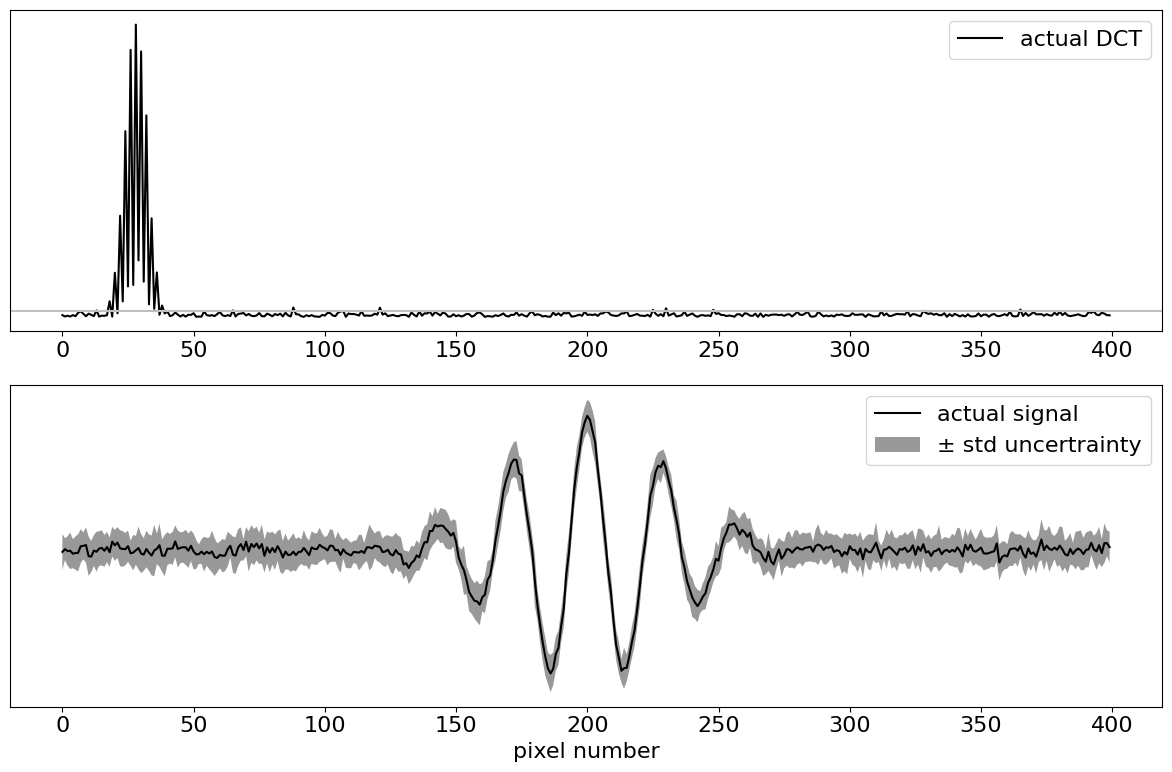

In [110]:
target_DCT = spfft.dct(target, norm= "forward")

threshold = np.abs(target_DCT).mean()

plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(2,1, figsize= (12,8))

axs[0].plot(np.abs(target_DCT), color= "k", label= "actual DCT")
axs[0].hlines(threshold, 0, 1, color= "silver", transform=axs[0].get_yaxis_transform())

axs[1].plot(target, color= "k", label= "actual signal")
axs[1].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs[1].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right') for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()


C:\Users\syf83691\AppData\Local\Temp\ipykernel_8872\1741690778.py:4: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs #in pixels


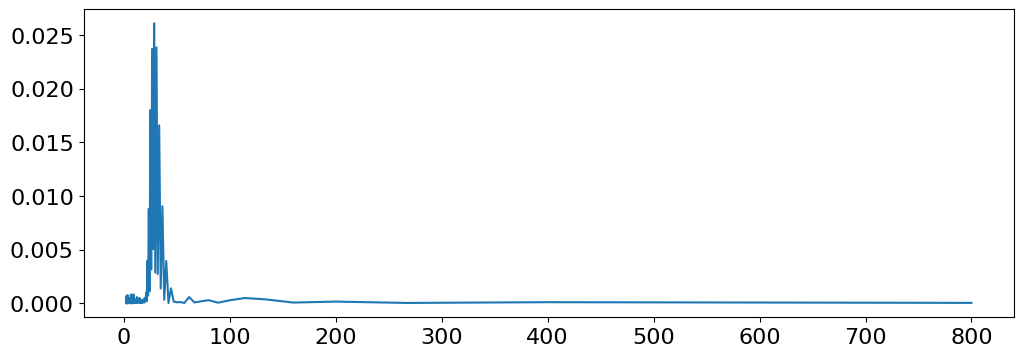

In [111]:
N = len(target_DCT)
k = np.arange(N)
freqs = k/(2*N) #in pixels^-1
wavelengths = 1/freqs #in pixels
freqs *= total_points #in "per array length"
wavelengths = np.nan_to_num(wavelengths, nan= np.nan, neginf= np.nan, posinf= np.nan)
half_wavelengths = wavelengths/2

fig, axs= plt.subplots(figsize= (12, 4))

axs.plot(wavelengths, np.abs(target_DCT))
#axs.set(xscale= "log")

plt.show()

In [112]:
reduced_points = 8

#I'm surprised that numpy and scipy don't have meathods for reading files with inconsistant numbers of delimiters.
optlocs_file = "data\\" + file_name +"_optlocs.csv"


with open(optlocs_file, 'r') as file:
    lines = [line[:-1] for line in list(file)]
    lines = [line for line in lines if line.count(",") == reduced_points-1] # filter by number of samples
    number_of_delimiters = [line.count(",") for line in lines]
    max_delimiters = max(number_of_delimiters)
    missing_delimiters = [max_delimiters -delimiters for delimiters in number_of_delimiters]
    data = [line.split(",") for line in lines]
    data = [[int(datapoint) for datapoint in line] for line in data] #2D list comprehention!!!!
    full_data = [data[n] + [np.nan]*missing_delimiters[n] for n in range(len(lines))]
    full_data = np.array(full_data)
    file.close()

print(len(lines))
print(total_points /reduced_points)

106
50.0


### REDUNDENT BASELINES

In [113]:
test = subsample_1d(total_points, reduced_points/total_points, subsampling_method= "regular") #[123,144,165,186,200,221,242,378]
test = np.array(test)

len(test)

8

In [114]:
np.diff(test)

array([57, 57, 57, 57, 57, 57, 57])

In [115]:
test

array([  0,  57, 114, 171, 228, 285, 342, 399])

In [116]:
full_data = np.vstack([full_data, test])
full_data.shape

(107, 8)

In [117]:
regularization_coeffient = 1e-4

def find_error(locations):
    assert locations.ndim == 1
    locations = locations[~np.isnan(locations)].astype(int)

    result = compressed_sensing(target[locations], locations, total_points, regularization_coeffient)
    error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

    return error

errors = [find_error(locations) for locations in tqdm(full_data)]
errors = np.array(errors)


100%|██████████| 107/107 [00:01<00:00, 55.48it/s]


In [118]:
sort = np.argsort(errors)
print(errors[-1])
errors = errors[sort]
full_data = full_data[sort]

62.134708450707826


In [119]:
print(*zip(errors, full_data), sep= "\n")

(31.74793599421752, array([  4,  56, 130, 171, 237, 271, 367, 395]))
(31.87541987109501, array([  6,  65, 118, 167, 213, 287, 331, 393]))
(32.65018740263547, array([  8,  63, 114, 166, 213, 287, 333, 391]))
(33.07120772970349, array([  5,  72, 113, 186, 233, 282, 333, 391]))
(33.077145531237896, array([ 10,  62, 117, 166, 213, 287, 330, 391]))
(34.035843499740785, array([  5,  64, 132, 171, 243, 278, 335, 398]))
(34.50742517341072, array([  3,  55, 107, 184, 235, 288, 346, 396]))
(34.61590778281336, array([  4,  52, 108, 184, 234, 291, 344, 393]))
(34.889997644297864, array([  6,  55, 107, 184, 235, 285, 343, 393]))
(34.91973543968664, array([  4,  52, 106, 184, 234, 285, 343, 394]))
(34.985655769012475, array([  5,  63, 116, 144, 242, 280, 343, 396]))
(35.431453852444804, array([  0,  63, 111, 186, 233, 279, 339, 389]))
(35.548864479168955, array([  5,  52, 111, 166, 214, 293, 340, 394]))
(35.61358611280335, array([  5,  55, 111, 166, 214, 294, 344, 396]))
(35.61634118366855, array([ 

In [120]:
sa_error = find_error(test)
brute_errors = np.empty((reduced_points, total_points))

fixed_points = np.repeat(test[None, :], reduced_points, axis= 0)
fixed_points = fixed_points[~np.eye(reduced_points, dtype= bool)] #one of the samples is not fixed
fixed_points = fixed_points.reshape((reduced_points, reduced_points-1)) #tell numpy to stop flattening my array

for n in np.arange(reduced_points):
    trail_samples = np.copy(test)
    for trail_sample in np.arange(total_points):
        trail_samples[n] = trail_sample
        brute_error = find_error(trail_samples) #This is the chi-squared
        brute_errors[n, trail_sample] = brute_error

-26.95817952547297


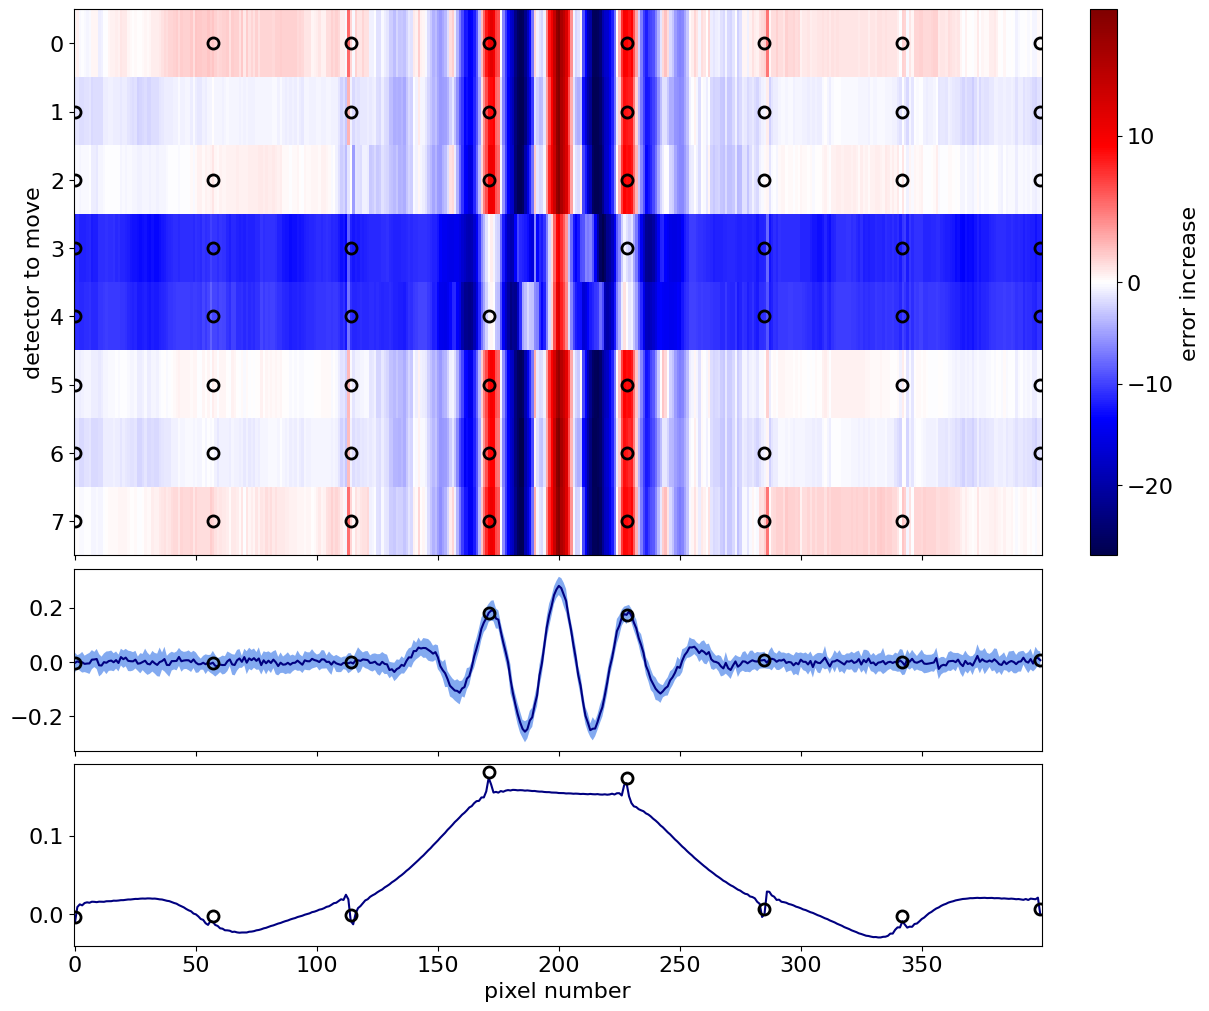

In [140]:
difference = brute_errors -sa_error

max_diff = np.max(difference)
min_diff = np.min(difference)
print(min_diff) # If this is less than zero then SA failed to find the best solution.

pos_zticks = np.arange(0, max_diff, 10**np.floor(np.log10(np.abs(max_diff))))
neg_zticks = np.arange(0, min_diff, -10**np.floor(np.log10(np.abs(min_diff)))) # np.floor() is NOT the same as int() for negative numbers!
zticks = np.unique(np.concatenate([pos_zticks, neg_zticks]))

fig, axs = plt.subplots(3, 1, figsize= (12, 10), sharex= True, height_ratios= (3, 1, 1), layout= "constrained")

norm = mplcolors.TwoSlopeNorm(0, vmin=min_diff, vmax=max_diff) #Greatly exagerates the possible improvements
im = axs[0].imshow(difference, aspect= "auto", interpolation= "none", cmap= "seismic", norm= norm)
plt.colorbar(im, ticks= zticks, label= "error increase")

axs[0].plot(fixed_points ,np.arange(reduced_points), linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8) #kind of cursed but it works
axs[0].set(ylabel= "detector to move")

axs[1].plot(target, color= "navy", label= "actual signal")
axs[1].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "cornflowerblue", alpha= 0.8, label= "± std uncertrainty")
axs[1].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)

axs[2].plot(compressed_sensing(target[test], test, total_points, regularization_coeffient), color= "navy")
axs[2].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)
axs[2].set(xlabel= "pixel number")

plt.show()